In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import heapq
from sklearn.impute import SimpleImputer
import pandas as pd
import json

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield json.loads(l)

In [3]:
# Read data
dataset = []
for l in readGz("renttherunway_final_data.json.gz"):
    dataset.append(l)
random.shuffle(dataset)

allRatings = []
for datum in dataset:
    if datum['rating'] is None:
        continue
    allRatings.append((datum['user_id'], datum['item_id'], int(datum['rating'])))

In [4]:
len(allRatings)

192462

In [5]:
# Split train, valid, test
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_size = int(len(dataset) * train_ratio)
val_size = int(len(dataset) * val_ratio)

ratingsTrain = allRatings[:train_size]
ratingsVal = allRatings[train_size:train_size + val_size]
ratingsTest = allRatings[train_size + val_size:]

In [6]:
def MSE(predictions, y):
    diff = [(pred - true)**2 for (pred, true) in zip(predictions, y)]
    return sum(diff) / len(diff)

In [ ]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
ratingDict = {} # To retrieve a rating for a specific user/item pair

for d in ratingsTrain:
    user,item = d[0], d[1]
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    ratingDict[(user,item)] = d[2]

In [8]:
userAverages = {}
itemAverages = {}
ratingMean = []

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)
    
for d in ratingsTrain:
    ratingMean.append(d[2])
    
ratingMean = sum(ratingMean) / len(ratingMean)

In [60]:
# Method 1: Collaborative Filtering based on Jaccard similarity of Users

In [9]:
jaccard_users = {}
jaccard_books = {}

In [10]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [11]:
def predictRating(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d[1]
        if i2 == item: continue
        ratings.append(d[2] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        return ratingMean

In [12]:
y = [d[2] for d in ratingsTest]
predictions = []
for u, i, r in ratingsTest:
    predictions.append(predictRating(u, i))
MSE(y, predictions)

2.196463768043665

In [13]:
userSet = set()
bookSet = set()
readSet = set()

for u,b,r in allRatings:
    userSet.add(u)
    bookSet.add(b)
    readSet.add((u,b))

lUserSet = list(userSet)
lBookSet = list(bookSet)

In [ ]:
# Latent Factor

In [14]:
trainRatings = [r[2] for r in ratingsTrain]
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)

In [29]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u, b, r in ratingsTrain:
    ratingsPerUser[u].append((b, r))
    ratingsPerItem[b].append((u, r))

def iterate(lamb, betaU, betaI):
    newAlpha = 0
    for u, b, r in ratingsTrain:
        newAlpha += r - (betaU[u] + betaI[b])
    alpha = newAlpha / len(ratingsTrain)

    for u in ratingsPerUser:
        newBetaU = 0
        for b, r in ratingsPerUser[u]:
            newBetaU += r - (alpha + betaI[b])
        betaU[u] = newBetaU / (lamb + len(ratingsPerUser[u]))
    
    for b in ratingsPerItem:
        newBetaI = 0
        for u, r in ratingsPerItem[b]:
            newBetaI += r - (alpha + betaU[u])
        betaI[b] = newBetaI / (lamb + len(ratingsPerItem[b]))

    mse = 0
    for u, b, r in ratingsTrain:
        prediction = alpha + betaU[u] + betaI[b]
        mse += (r - prediction) ** 2

    regularizer = 0
    for u in betaU:
        regularizer += betaU[u] ** 2
    for b in betaI:
        regularizer += betaI[b] ** 2

    mse /= len(ratingsTrain)

    val_mse = 0
    for u, b, r in ratingsVal:
        val_mse += (alpha + betaU[u] + betaI[b] - r) ** 2
    val_mse /= len(ratingsVal)

    return mse, mse + lamb * regularizer, alpha, val_mse, betaU, betaI

In [48]:
# Collecting data for plotting
lamb_values = []
train_mses = []
valid_mses = []
test_mses = []

In [49]:
import matplotlib.pyplot as plt

best_lambda = None
best_train_mse = float('inf')
best_valid_mse = float('inf')
best_test_mse = float('inf')

for lamb in np.arange(8.1, 8.3, 0.01):
    betaU, betaI = defaultdict(float), defaultdict(float)
    # mse,objective, _, _ = iterate(lamb)
    # newMSE,newObjective, _, _ = iterate(lamb)
    # iterations = 2
    mse, objective = 0, 0
    newMSE, newObjective = 0, 0
    valid_mse = 0
    iterations = 0

    while iterations < 10 or objective - newObjective > 0.001:
        mse, objective = newMSE, newObjective
        newMSE, newObjective, alpha, valid_mse, betaU, betaI = iterate(lamb, betaU, betaI)
        iterations += 1
        # print("Objective after "
        #       + str(iterations) + " iterations = " + str(newObjective))
        # print("MSE after "
        #       + str(iterations) + " iterations = " + str(newMSE))
        # print("Valid MSE after "
        #       + str(iterations) + " iterations = " + str(valid_mse))

    # valid_mse = 0
    # for u, b, r in ratingsVal:
    #     valid_mse += (alpha + betaU[u] + betaI[b] - r)**2
    # valid_mse = valid_mse / len(ratingsVal)

    test_mse = 0
    for u, b, r in ratingsTest:
        test_mse += (alpha + betaU[u] + betaI[b] - r)**2
    test_mse = test_mse / len(ratingsTest)
    
    if valid_mse < best_valid_mse:
        best_lambda = lamb
        best_train_mse = newMSE
        best_valid_mse = valid_mse
        best_test_mse = test_mse
    
    lamb_values.append(lamb)
    train_mses.append(newMSE)
    valid_mses.append(valid_mse)
    test_mses.append(test_mse)

    print(f"lambda: {lamb}, train mse: {newMSE}, valid mse: {valid_mse}, test mse: {test_mse} | best lambda: {best_lambda}, best valid mse: {best_valid_mse}, best train mse: {best_train_mse}, best test mse: {best_test_mse}")

print("\nBest Results:")
print(f"Best lambda: {best_lambda}")
print(f"Best train mse: {best_train_mse}")
print(f"Best valid mse: {best_valid_mse}")

lambda: 8.1, train mse: 1.4989588692080027, valid mse: 1.9228458589762065, test mse: 1.9218752570995379 | best lambda: 8.1, best valid mse: 1.9228458589762065, best train mse: 1.4989588692080027, best test mse: 1.9218752570995379
lambda: 8.11, train mse: 1.4993012478669894, valid mse: 1.9228450891740112, test mse: 1.9218637407647112 | best lambda: 8.11, best valid mse: 1.9228450891740112, best train mse: 1.4993012478669894, best test mse: 1.9218637407647112
lambda: 8.12, train mse: 1.4996430540168617, valid mse: 1.9228443755734481, test mse: 1.9218522995231426 | best lambda: 8.12, best valid mse: 1.9228443755734481, best train mse: 1.4996430540168617, best test mse: 1.9218522995231426
lambda: 8.129999999999999, train mse: 1.4999842892123108, valid mse: 1.9228437179126356, test mse: 1.9218409330600257 | best lambda: 8.129999999999999, best valid mse: 1.9228437179126356, best train mse: 1.4999842892123108, best test mse: 1.9218409330600257
lambda: 8.139999999999999, train mse: 1.50032495

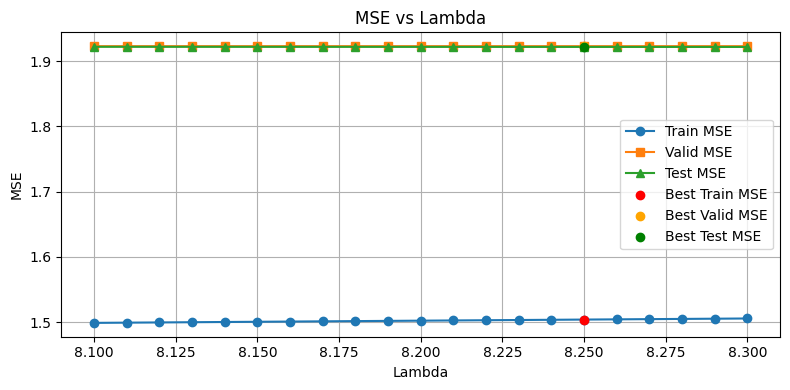

In [50]:
# Plotting results
plt.figure(figsize=(8, 4))  # Aspect ratio 3:1
plt.plot(lamb_values, train_mses, label='Train MSE', marker='o', linestyle='-')
plt.plot(lamb_values, valid_mses, label='Valid MSE', marker='s', linestyle='-')
plt.plot(lamb_values, test_mses, label='Test MSE', marker='^', linestyle='-')

# Highlighting the best lambda
plt.scatter([best_lambda], [best_train_mse], color='red', label='Best Train MSE', zorder=5)
plt.scatter([best_lambda], [best_valid_mse], color='orange', label='Best Valid MSE', zorder=5)
plt.scatter([best_lambda], [best_test_mse], color='green', label='Best Test MSE', zorder=5)

# Adding labels and legend
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
lamb = 8.249999999999996
alpha = globalAverage
betaU, betaI = defaultdict(int), defaultdict(int)
mse,objective, _ = iterate(lamb)
newMSE,newObjective, _ = iterate(lamb)
iterations = 2
while iterations < 10 or objective - newObjective > 0.00001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective, alpha = iterate(lamb)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))
    valid_mse = 0
    for u, b, r in ratingsVal:
        valid_mse += (alpha + betaU[u] + betaI[b] - r)**2
    valid_mse = valid_mse / len(ratingsVal)
    print("Valid mSE after "
        + str(iterations) + " iterations = " + str(valid_mse))

In [ ]:
# SVD

In [55]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import mse


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/homebrew/Cellar/python@3.10/3.10.15/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/homebrew/Cellar/python@3.10/3.10.15/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/yudingyi/Documents/Projects/258Final/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [ ]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(1, 5))
data = Dataset.load_from_df(pd.DataFrame(allRatings, columns=['user', 'item', 'rating']), reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.05)
trainset_as_test = trainset.build_testset()
train_predictions = model.test(trainset_as_test)

In [ ]:
for n_factors in range(1, 5):
    for reg_all in range(1, 5):
        model = SVD(n_factors=n_factors, reg_all=reg_all/100)
        model.fit(trainset)
        train_predictions = model.test(trainset_as_test)
        train_error = mse(train_predictions)
        test_predictions = model.test(testset)
        test_error = mse(test_predictions)
        print(f"n factor: {n_factors}, reg: {reg_all}, train mse: {train_error}, test mse: {test_error}")

In [ ]:
model = SVD(n_factors=1, reg_all=0.03)
model.fit(trainset)

In [ ]:
res = model.predict('u11538900', 'b07888199')
res.est

In [ ]:
predictions = open("predictions_Rating.csv", 'w')
for l in open("pairs_Rating.csv"):
    if l.startswith("userID"):
        #header
        predictions.write(l)
        continue
    u,b = l.strip().split(',')
    # res = alpha + betaU[u] + betaI[b]
    res = model.predict(u, b).est
    predictions.write(u + ',' + b + ',' + str(res) + '\n')

predictions.close()